# Analyze A/B Test Results 



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [36]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [37]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [38]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [39]:
df.user_id.nunique()

290584

In [40]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

**d.** The proportion of users converted.

In [41]:
converted = len(df.query('converted == 1'))/df.shape[0]
converted

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [42]:
df_unique = df.drop_duplicates(subset='user_id', keep="first")
df_unique.shape

(290584, 5)

In [43]:
treatment = df.query('group == "treatment" & landing_page != "new_page"')
control =df.query('group == "control" & landing_page == "new_page"')
control.shape[0] + treatment.shape[0]

3893

In [44]:
df.head() #group is treatment but landing_page is not != new_page

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**f.** Do any of the rows have missing values?

In [45]:
df.isna().sum().sum()

0

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  




**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [46]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2= df.drop(df[(df['group'] == "treatment") & (df['landing_page'] != "new_page")].index)
df2= df2.drop(df[(df['group']=='control')&(df['landing_page']=="new_page")].index)
print(df2.shape)
print(df.shape[0]-3893)

(290585, 5)
290585


In [47]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [48]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [49]:
duplicate= df2[df2.duplicated(['user_id'])]

**c.** Display the rows for the duplicate **user_id**? 

In [50]:
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [51]:
# Remove one of the rows with a duplicate user_id..
duplicate = duplicate.index
df2= df2.drop(duplicate)
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.nunique()

290584

In [52]:
df2.shape[0]

290584

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [53]:
Ppopulation= len(df2[df2['converted']== 1])/len(df2)
Ppopulation

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [54]:
control_df2= df2[df2['group']=='control']
control_converted = len(control_df2[control_df2['converted']==1])/len(control_df2)
control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [55]:
treatment_df2= df2[df2['group']=='treatment']
treatment_converted = len(treatment_df2[treatment_df2['converted']==1])/len(treatment_df2)
treatment_converted

0.11880806551510564

In [56]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff= treatment_converted - control_converted
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [57]:
Pnew_page= len(df2[df2['landing_page']=='new_page'])/len(df2)
Pnew_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Based on the data above, the old page sees a slightly higher conversion rate.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Null hypothesis: Pnew - Pold <= 0**


> **Alternative hypothesis:  Pnew - Pold > 0**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [58]:
Pnew_null = df2['converted'].mean()
Pnew_null

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [59]:
Pnew_null

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [60]:
n_new = df2.query('landing_page=="new_page"')
len(n_new)

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [61]:
n_old = df2.query('landing_page=="old_page"')
len(n_old)

145274

In [62]:
Pnew_null- Pnew_null

0.0

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [63]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size=len(n_new),p=[Pnew_null, 1-Pnew_null])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [64]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], size=len(n_old),p=[Pnew_null, 1-Pnew_null])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [65]:
new_page_converted.mean() - old_page_converted.mean()

-0.0035052800545300605


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [66]:
# Sampling distribution 
p_diffs = []
for _ in range (10000):
    Pnew= (np.random.choice([1,0], size= len(n_new), p=[Pnew_null,1-Pnew_null])).mean()
    Pold= (np.random.choice([1,0], size= len(n_old), p=[Pnew_null,1-Pnew_null])).mean()
    p_diffs.append(Pnew-Pold)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

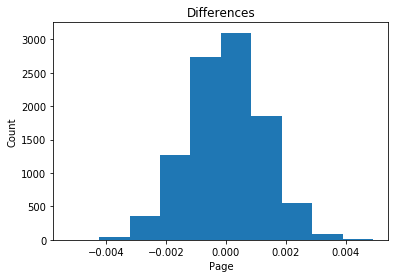

In [67]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.title("Differences")
plt.xlabel("Page")
plt.ylabel("Count")
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [68]:
(p_diffs>obs_diff).mean()

0.90000000000000002

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>The value obtained above is called the *P-Value*, the P-value tells us the probability of a statistic if H0 is true. Because the p-value is so large, this means we have **failed to reject the null, meaning, we should stick to the old page**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [69]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page =="old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page=="new_page"'))

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



In [70]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>The z-score and p-value from the test above suggest that conversion rates between the old and new page are not statistically significant. In addition, the p-value is very similar to the one computed earlier which is further confirmation that we have **failed to reject the null hypothesis**.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic regression:** Because conversion values are binary, we will be using logistic regression which is limited to 2 values, whereas linear regression's variable values are unconstrained.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [71]:
df2['intercept']=1
df2['ab_page']= pd.get_dummies(df2['group'])['treatment']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [72]:
logit_mod= sm.Logit(df2['converted'],df2[['intercept','ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [73]:
results= logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-11 01:41 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>The p-value associated with *ab_page* is .1899. Part 2 compared conversion rates between pages considering that old_page was better than the new one which gave us a p-value of .90 and is a one-sided test, whereas the p-value associated with ab_page is looking at a two sided test.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>It is a good idea to consider other factors into our regression model because it could give us a deeper insight between the relationship columns have with one another(ex. time spent on page, ctr). However, these additional terms could be more harmful than insightful if we end up adding too many since it will make the model much more difficult to interpret.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [74]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [75]:
# Join with the df2 dataframe
df_merged= df2.merge(countries, on='user_id', how='left')

In [76]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']]= pd.get_dummies(df_merged['country'])
df_merged=df_merged.drop(df_merged['CA'])

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


In [77]:
df_merged['intercept']=1
df_merged['UK_page']=df_merged['UK']*df_merged['ab_page']
df_merged['US_page']=df_merged['US']*df_merged['ab_page']
log_mod2= sm.Logit(df_merged['converted'],df_merged[['intercept','UK','UK_page','US','US_page','ab_page']])
results= log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-11 01:41 AIC:              212782.1460
No. Observations:   290582           BIC:              212845.6239
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290576           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US             0.0176    0.0377    0.4657  0.6414  -0.0563   0.0914
US_page        0.0469    0.0538    0.8714  0.3835  -0.0585   0.1523
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

In [59]:
df['timestamp'][0]

'2017-01-21 22:11:48.556739'

In [60]:
df['timestamp'].tail(1)

294477    2017-01-16 12:40:24.467417
Name: timestamp, dtype: object

>The data above shows us that the country of origin of the user is not significant to our conversion rates. (This based on having p-values >.05)

> **Based on the data, we have failed to reject the null hypothesis.** However, this could be a result of *change aversion*, to make a well-informed decision, we should run this A/B test for more time (considering this experiment only ran for 5 days, which is not enough to create a fair assesment.

>**Statistical Reasoning:**
>The z-score and p-value from the tests above suggest that conversion rates between the old and new page are not statistically significant. The histogram, on the other hand, shows a decrease in conversion with the new_page compared to the old one.  Furthermore, none of the variables we explored have significant p-values, yet again confirmation that we have not succeeded to reject the null. Lastly, the last test performed with Logistic regression to analyze the relationship between conversion and country didn't provide sufficient evidence to suggest that users from differennt countries see higher/lower conversion. Taking all of this into consideration, we can say that, with the data we have right now, we have **failed to reject the null** 

>**Suggestions based on outcome:**
Based on these results, I would recommend running the new page for a couple more days to collect more data, and if the results continue to be what they are now (or similar), we stick with the old page. 